(Las siguientes 2 celdas son sólo para correr en Google Collab)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd '/content/drive/MyDrive/Tesis/Parte 1'

Ejercicio introductorio del proyecto de tesis. Como parte del proceso de familiarización con el conjunto de datos que se utilizará, la primera actividad consiste simplemente en identificar y separar los mensajes del foro que están asociados a programas escritos en javascript (ID de JS: 5). Se usará la base de datos "tiny" de Mumuki compartida [aquí](https://docs.google.com/document/d/1V2UVQ_L8o5clzliSm3isD1WH7nbYSOOVqztMYSfaNkY/edit#), en la cual tendrían que existir 5324 mensajes en un total de 4242 discusiones (lo cual también se comprobará a continuación)

In [ ]:
%run jsfilter.py db/discussions_anon.csv db/messages_anon.csv db/items_anon.csv

Usamos un script aparte para generalizar; es un programa pequeño que hace uso de la librería **csv** para manipular este tipo de datos, y diccionarios para conservar los nombres de los campos. Filtramos las discusiones como se haría con una query; primero guardamos información sobre el lenguaje al que corresponde cada ejercicio (lo cual está en otra tabla), pero lo hacemos 1 sola vez. Se asume como precondición que los campos 'id' y 'language_id' existen en la tabla de *items*, y que 'item_id' existe en la tabla de *discussions*. Se hace lo mismo con los mensajes (los cuales tienen un campo *discussion_id*)

A continuación, los primeros intentos de análisis sobre los datos provistos.

In [2]:
from zmq.constants import DELAY_ATTACH_ON_CONNECT
import csv

with open('db/discussions_anon.csv', newline='',encoding='utf8') as discs:
  discs_reader = csv.DictReader(discs)
  discs_data = [(int(d['messages_count']), d['status'], len(d['description'])) for d in discs_reader]

with open('db/discussions_anon_js_T.csv', newline='',encoding='utf8') as discsJS:
  discsJS_reader = csv.DictReader(discsJS)
  discsJS_data = [(int(d['messages_count']), d['status'], len(d['description'])) for d in discsJS_reader]

with open('db/messages_anon.csv', newline='',encoding='utf8') as msgs:
  msgs_reader = csv.DictReader(msgs)
  msgs_data = [len(m['content']) for m in msgs_reader]

with open('db/messages_anon_js_T.csv', newline='',encoding='utf8') as msgsJS:
  msgsJS_reader = csv.DictReader(msgsJS)
  msgsJS_data = [len(m['content']) for m in msgsJS_reader]

d_len = len(discs_data)
djs_len = len(discsJS_data)
js_percent = round(djs_len*100/d_len, 3)

m_len = len(msgs_data)
mjs_len = len(msgsJS_data)
js_percent2 = round(mjs_len*100/m_len, 3)

d_msgCount = round(sum(data[0] for data in discs_data)/d_len, 3)
d_msgMax = max(data[0] for data in discs_data)
djs_msgCount = round(sum(data[0] for data in discsJS_data)/djs_len, 3)
djs_msgMax = max(data[0] for data in discsJS_data)

d_solved = sum(1 for data in discs_data if data[1] == 'solved')
d_solved_p = round(d_solved*100/d_len)
djs_solved = sum(1 for data in discsJS_data if data[1] == 'solved')
djs_solved_p = round(djs_solved*100/djs_len, 3)

d_empty = sum(1 for data in discs_data if data[2] == 0)
d_empty_p = round(d_empty*100/d_len)
djs_empty = sum(1 for data in discsJS_data if data[2] == 0)
djs_empty_p = round(djs_empty*100/djs_len, 3)

mjs_empty = sum(1 for data in msgsJS_data if data == 0)
mjs_empty_p = round(mjs_empty*100/mjs_len, 3)

djs_charLen = round(sum(data[2] for data in discsJS_data if data[2] != 0)/(djs_len - djs_empty), 3)
mjs_charLen = round(sum(data for data in msgsJS_data if data != 0)/(mjs_len - mjs_empty), 3)

# results
print(f'Discusiones totales: {d_len} - Discusiones sobre JS: {djs_len} ({js_percent}%)')
print(f'Mensajes totales: {m_len} - Mensajes sobre JS: {mjs_len} ({js_percent2}%)')
print(f'Promedio de mensajes: {d_msgCount} (nunca más de {d_msgMax}) - Promedio de mensajes sobre JS: {djs_msgCount} (nunca más de {djs_msgMax})')
print(f'Discusiones totales resueltas: {d_solved} ({d_solved_p}%) - Discusiones sobre JS resueltas: {djs_solved} ({djs_solved_p}%)')
print(f'Descripciones vacías: {d_empty} ({d_empty_p}%) - Descripciones vacías JS: {djs_empty} ({djs_empty_p}%)')
print(f'Mensajes sobre JS vacíos: {mjs_empty} ({mjs_empty_p}%)')
print(f'Longitud promedio de descripciones no vacías sobre JS: {djs_charLen} - Longitud promedio de mensajes no vacíos sobre JS: {mjs_charLen}')



Discusiones totales: 4242 - Discusiones sobre JS: 441 (10.396%)
Mensajes totales: 5324 - Mensajes sobre JS: 964 (18.107%)
Promedio de mensajes: 1.255 (nunca más de 15) - Promedio de mensajes sobre JS: 2.186 (nunca más de 12)
Discusiones totales resueltas: 188 (4%) - Discusiones sobre JS resueltas: 55 (12.472%)
Descripciones vacías: 98 (2%) - Descripciones vacías JS: 4 (0.907%)
Mensajes sobre JS vacíos: 0 (0.0%)
Longitud promedio de descripciones no vacías sobre JS: 89.952 - Longitud promedio de mensajes no vacíos sobre JS: 239.948


Habiendo hecho las primeras pruebas, varias nuevas estadísticas de interés surgen naturalmente; nos interesa sistematizar la recopilación de datos, desde ahora limitándonos a Javascript, y generalizar lo más posible el código más útil.

En primer lugar, ya podemos ver la estructura que tiene esta base de datos, al menos de manera general:![Mumuki_schema.png](https://drive.google.com/uc?export=view&id=1i6DhRvdi667ge1aur4buE28MRNdXgfX4)

Conociendo las relaciones entre las tablas, podemos comprobar la **consistencia** de la base de datos. Un detalle importante que observamos es que si un id referenciado en la tabla *hijo* no está en la tabla *padre* (porque esta no es la BD completa), ninguna query que hagamos es confiable. En otras palabras, para cada discusión, tiene que estar presente el ejercicio y el usuario que la empezó; para cada mensaje, tiene que estar presente la discusión y el usuario que lo escribió. En principio, la consistencia está asegurada por quien se encarga de exportar la BD; este script es un *extra* separado de la temática del proyecto.

In [1]:
%run consistency_check.py db/discussions_anon_js.csv db/messages_anon_js.csv db/items_anon.csv db/participants_anon.csv

Tabla de discusiones consistente.
Tabla de mensajes consistente.


Habiendo comprobado la consistencia de la BD, nos interesa centrarnos en la diferenciación entre las redacciones de los tutores y los alumnos. Para esto, usamos un dato importante proporcionado por la empresa: **Los usuarios que son tutores corresponden a los uid 0, 2, 34, 50, 115, 959.**

Notar también que esta BD sólo tiene discusiones marcadas como **solved** (solucionadas) o **closed** (cerradas); no hay ninguna *abierta* ni *en revisión*. Lamentablemente, las discusiones cerradas no serán muy "útiles" para nuestro análisis (pues no reciben más respuesta ni hay una resolución), y estas representan casi el **96%** del total. A partir de charlas con profesores y la empresa, conseguimos algunos criterios que pueden mejorar ese número:

* Las discusiones catalogadas como *solved* son útiles.
* Las discusiones con mensajes **validados por mentores** (campo *approved*) se pueden considerar.
* Las discusiones con **mensajes de mentores** también.

El siguiente script es un filtro sobre las discusiones basado en esos criterios; en lugar de eliminar una parte, se separará la tabla en 2.

In [3]:
%run useful_slice.py db/discussions_anon_js.csv db/messages_anon_js.csv

In [4]:
from zmq.constants import DELAY_ATTACH_ON_CONNECT
import csv

with open('db/discussions_anon_js.csv', newline='',encoding='utf8') as discs:
  discs_reader = csv.DictReader(discs)
  discs_len = sum(1 for _ in discs_reader)

with open('db/discussions_anon_js_T.csv', newline='',encoding='utf8') as discsT:
  discsT_reader = csv.DictReader(discsT)
  discsT_len = sum(1 for _ in discsT_reader)

with open('db/discussions_anon_js_F.csv', newline='',encoding='utf8') as discsF:
  discsF_reader = csv.DictReader(discsF)
  discsF_len = sum(1 for _ in discsF_reader)

print(f'Discusiones sobre JS: {discs_len} - de las cuales:')
print(f'--Discusiones aprobadas: {discsT_len}')
print(f'--Discusiones desaprobadas: {discsF_len}')

with open('db/messages_anon_js.csv', newline='',encoding='utf8') as msgs:
  msgs_reader = csv.DictReader(msgs)
  msgs_len = sum(1 for _ in msgs_reader)

with open('db/messages_anon_js_T.csv', newline='',encoding='utf8') as msgsT:
  msgsT_reader = csv.DictReader(msgsT)
  msgsT_len = sum(1 for _ in msgsT_reader)

with open('db/messages_anon_js_F.csv', newline='',encoding='utf8') as msgsF:
  msgsF_reader = csv.DictReader(msgsF)
  msgsF_len = sum(1 for _ in msgsF_reader)

print(f'Mensajes sobre JS: {msgs_len} - de los cuales:')
print(f'--Mensajes aprobados: {msgsT_len}')
print(f'--Mensajes desaprobados: {msgsF_len}')

Discusiones sobre JS: 1419 - de las cuales:
--Discusiones aprobadas: 441
--Discusiones desaprobadas: 978
Mensajes sobre JS: 1719 - de los cuales:
--Mensajes aprobados: 964
--Mensajes desaprobados: 755


El aumento de discusiones utiles, de 55 a 441, ya resulta prometedor.

Antes de continuar, sería una buena idea generalizar este tipo de operaciones (en especial los *filtros*) como **queries** con predicados, para poder reunir datos más rápidamente.

Logramos esto en principio con dos funciones: **hardFilter**, que genera un archivo csv nuevo, y **softFilter** que sólo devuelve el filtro en una lista, para usar en cálculos intermedios.

In [5]:
import filterTools as ft

# filtro simple: todos los mensajes sobre JS de usuario con uid > 300
ft.hardFilter('db/messages_anon_js.csv', lambda msg: int(msg['sender_uid']) > 300, '_TEST')

# filtro compuesto: todas las discusiones que tienen algun mensaje con mas de 100 caracteres
longMsgs = ft.softFilter('db/messages_anon_js.csv', lambda msg: len(msg['content']) > 100)
ft.hardFilter('db/discussions_anon_js.csv', lambda disc: any(msg['discussion_id'] == disc['id'] for msg in longMsgs), '_TEST')

# no obstante, esta solución es menos eficiente

Filtrar ahora las discusiones "útiles", comprobar el resultado anterior, y extenderlo a los mensajes (esto es, todos los mensajes de discusiones útiles). Para hacer varios filtros simultaneos, puede ser mejor que softFilter también devuelva un arreglo (además de escribir un archivo). Pero para ahorrar código, hacemos una sola función **filter** con un parámetro extra **write** con default *False* (y un *tag*). Agregamos otro parámetro **saveField** para opcionalmente guardar en un **set** los campos que aplican (especialmente útil para foreign keys).

In [6]:
from filterTools import filter

tutors = [0, 2, 34, 50, 115, 959]
approved_discs = filter('db/messages_anon_js.csv', lambda msg: msg['approved'] == 'True' or int(msg['sender_uid']) in tutors, saveField='discussion_id')

def usefulDisc(disc):
  return disc['status'] != 'closed' or disc['id'] in approved_discs

discsT = filter('db/discussions_anon_js.csv', usefulDisc, write=True, tag='_T', saveField='id')
discsF = filter('db/discussions_anon_js.csv', lambda disc: not usefulDisc(disc), write=True, tag='_F', saveField='id')

_ = filter('db/messages_anon_js.csv', lambda msg: msg['discussion_id'] in discsT, write=True, tag='_T')
_ = filter('db/messages_anon_js.csv', lambda msg: msg['discussion_id'] in discsF, write=True, tag='_F')


Tras la última reunión, acordamos hacer algunos ajustes a la recopilación de datos. Primero, incluiremos el mensaje original de cada discusión como un *message* adicional (es decir, el conteo de mensajes es +1), y lo analizaremos como tal. Notar que **Mumuki no tiene jerarquía de mensajes**; esto es, todos los mensajes luego del 1er mensaje son respuestas al mismo. Segundo, usaremos medios visiuales para representar la información (como **histogramas** con el paquete *matplotlib*) y estadísticas adicionales, como la **varianza**.

Empecemos contando mensajes bajo estas condiciones, y agregamos además que tienen que pertenecer a discusiones 'útiles'.

Matplotlib is building the font cache; this may take a moment.


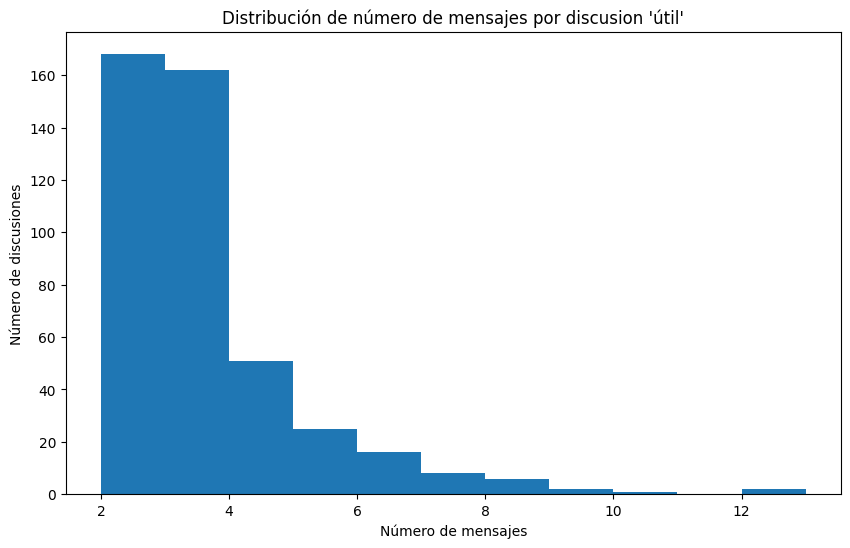

Promedio de mensajes: 3.186 - Desviación estándar: 1.5407790237409127


In [8]:
from filterTools import filter
import numpy as np
import matplotlib.pyplot as mlp
from math import sqrt

discs = filter('db/discussions_anon_js_T.csv', lambda _: True)

msgCount = [int(disc['messages_count']) + 1 for disc in discs]
msgMean = round(np.mean(msgCount), 3)
msgVar = round(np.var(msgCount), 3)

mlp.rcParams['figure.figsize'] = [10, 6]
mlp.title("Distribución de número de mensajes por discusion 'útil'")
mlp.xlabel('Número de mensajes')
mlp.ylabel('Número de discusiones')
msgHist = mlp.hist(msgCount, bins=range(min(msgCount), max(msgCount)+1,))
mlp.show()
print(f'Promedio de mensajes: {msgMean} - Desviación estándar: {sqrt(msgVar)}')

Dejando este ejemplo de lado, avanzamos hacia la temática central del proyecto haciendo uso de la librería **spacy** de análisis de lenguaje natural.

Haremos las primeras pruebas en jupyter, pero dejamos registrados los comandos de instalación para cuando sean necesarios. Entorno virtual:
```
python -m venv .env
source .env/bin/activate
```

Spacy (como recomienda en su página):
```
pip install -U pip setuptools wheel
pip install -U spacy
```

Pipeline entrenada para procesar español (eficiente):
```
python -m spacy download es_core_news_sm
```

Pipeline entrenada para procesar español (precisa):
```
python -m spacy download es_dep_news_trf
```

Si solo necesitamos tokenizar, podemos usar el cógigo de lenguage **'es'** sin recurrir a ninguna pipeline.

In [ ]:
import spacy as sp
from filterTools import filter

msgs = filter('db/messages_anon_js_T.csv', lambda _: True)
nlp = sp.blank("es")

# tomar el 1er mensaje como ejemplo
doc = nlp(msgs[0]['content'])
print(f'TOKENS: {len(doc)}\n')
for token in doc:
    print(token.text)

Otras estadísticas a partir del tokenizado: conteo de la cantidad de *tokens* por mensaje (en lugar de caracteres, lo cual no es muy útil)

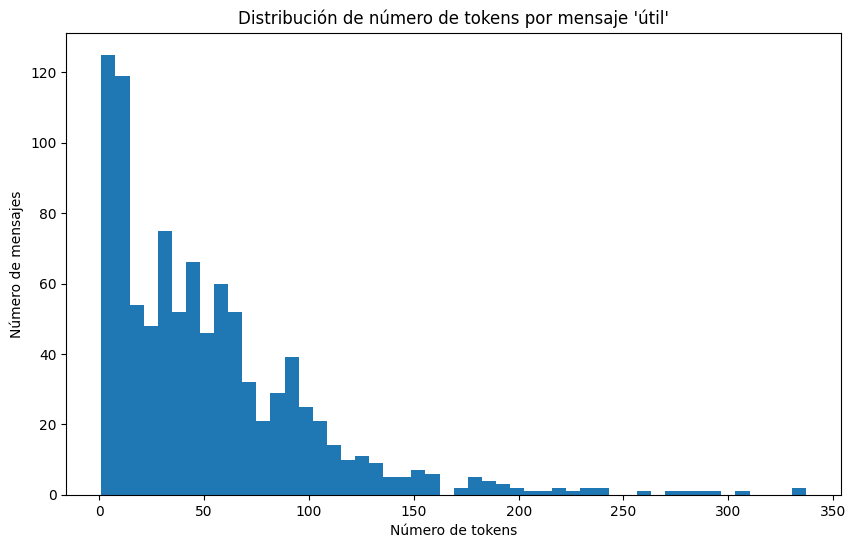

Promedio de tokens: 53.051 - Desviación estándar: 49.377180964490066
Mediana: 169.0


In [9]:
import spacy as sp
from filterTools import filter
import numpy as np
import matplotlib.pyplot as mlp
from math import sqrt

msgs = filter('db/messages_anon_js_T.csv', lambda _: True)
nlp = sp.load('es_core_news_sm')

docs = [nlp(msg['content']) for msg in msgs]
lengths = [len(doc) for doc in docs]

tokenMean = round(np.mean(lengths), 3)
tokenVar = round(np.var(lengths), 3)

mlp.rcParams['figure.figsize'] = [10, 6]
mlp.title("Distribución de número de tokens por mensaje 'útil'")
mlp.xlabel('Número de tokens')
mlp.ylabel('Número de mensajes')
mlp.hist(lengths, bins=50)
mlp.show()
print(f'Promedio de tokens: {tokenMean} - Desviación estándar: {sqrt(tokenVar)}')
print(f'Mediana: {(min(lengths) + max(lengths))/2}')

Luego, nos interesamos más en analizar el texto en sí; por ejemplo, viendo las palabras más (o menos) comunes:

('*', 2695)
(',', 2397)
('que', 2203)
('`', 1648)
('.', 1605)
('el', 1342)
('la', 1283)
(')', 1275)
('de', 1059)
('en', 848)
('"', 838)
('no', 826)
('es', 809)
('y', 806)


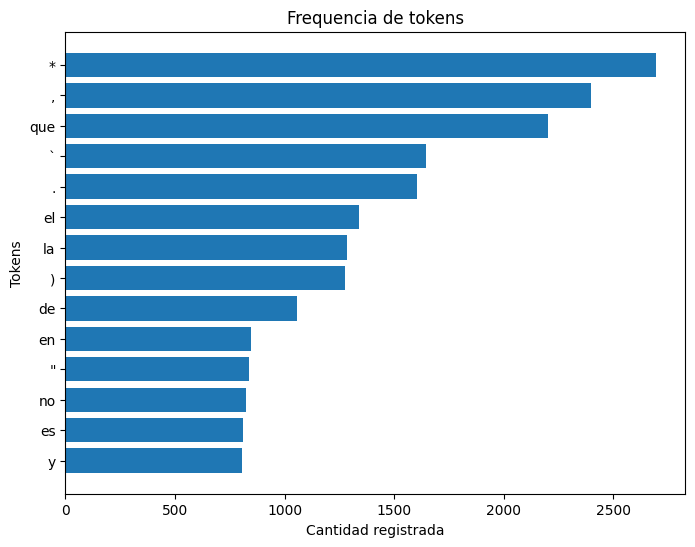

In [11]:
import spacy as sp
from filterTools import filter
import matplotlib.pyplot as mlp
import pandas as pd

msgs = filter('db/messages_anon_js_T.csv', lambda _: True)
discs = filter('db/discussions_anon_js_T.csv', lambda _: True)
nlp = sp.load('es_core_news_sm')

words = {}
docs = [nlp(msg['content']) for msg in msgs]
for doc in docs:
  for token in doc:
    text = (token.text).lower()
    words[text] = words.get(text, 0) + 1

docs = [nlp(disc['description']) for disc in discs]
for doc in docs:
  for token in doc:
    text = (token.text).lower()
    words[text] = words.get(text, 0) + 1

freqWords = sorted(words.items(), key=lambda x: x[1], reverse=True)[:14]
for w in freqWords:
  print(w)

df = pd.DataFrame(
    dict(
        words = [word[0] for word in freqWords],
        freq = [word[1] for word in freqWords]
    )
)

mlp.rcParams['figure.figsize'] = [8, 6]
mlp.title("Frequencia de tokens")
mlp.ylabel('Tokens')
mlp.xlabel('Cantidad registrada')
mlp.barh('words', 'freq', data=df.sort_values('freq'))
mlp.show()

A partir de aquí, usaremos estos resultados para hacer consultas que habían quedado acordadas en la útima reunión. Primero, la cantidad de discusiones y de mensajes, respectivamente, asociados a cada ejercidio.

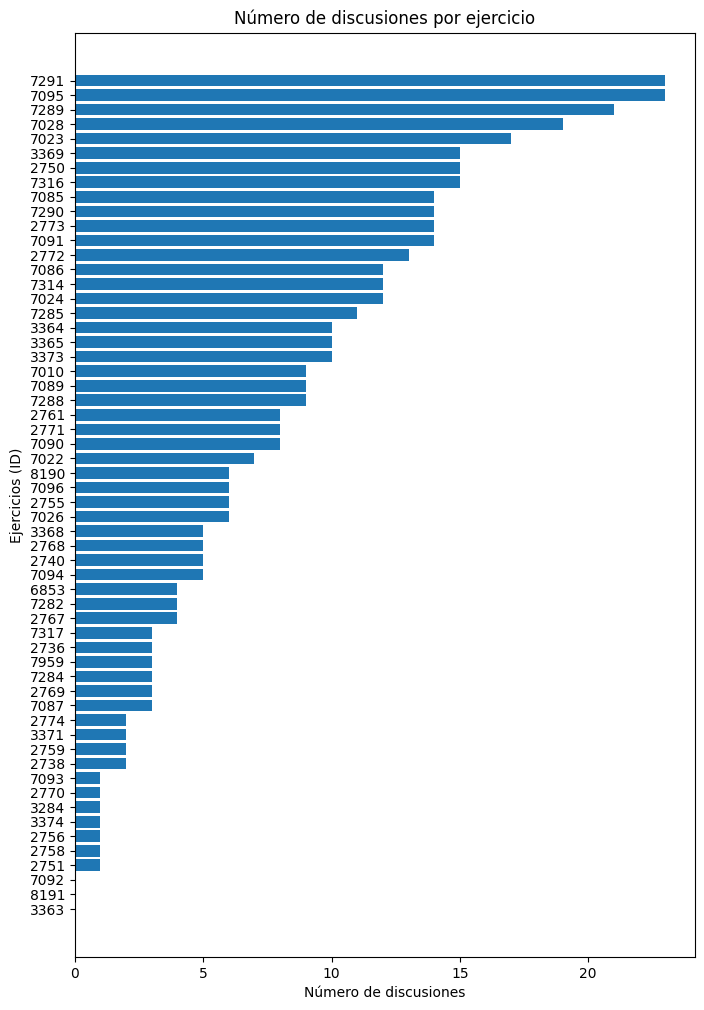

In [12]:
from filterTools import filter
import matplotlib.pyplot as mlp
import pandas as pd

discs = filter('db/discussions_anon_js_T.csv', lambda _: True)
msgs = filter('db/messages_anon_js_T.csv', lambda _: True)
items = filter('db/items_anon.csv', lambda item: item['language_id'] == '5')

discItems = {d['id']: d['item_id'] for d in discs}

itemsM = {i['id']: 0 for i in items}
for msg in msgs:
  itemId = discItems[msg['discussion_id']]
  itemsM[itemId] = itemsM.get(itemId, 0) + 1

itemsD = {i['id']: 0 for i in items}
for (d, i) in discItems.items():
  itemsD[i] = itemsD.get(i, 0) + 1

msgFrame = pd.DataFrame(
    dict(
        items1 = list(itemsM.keys()),
        freq1 = list(itemsM.values())
    )
)

discFrame = pd.DataFrame(
    dict(
        items2 = list(itemsD.keys()),
        freq2 = list(itemsD.values())
    )
)

mlp.rcParams['figure.figsize'] = [8, 12]
#sp1 = mlp.subplot(1, 2, 1)
#sp1.set_title("Número de mensajes por ejercicio")
#sp1.set_xlabel("Número de mensajes")
#sp1.set_ylabel("Ejercicios (ID)")
#mlp.barh('items1', 'freq1', data=msgFrame.sort_values('freq1'))

sp2 = mlp.subplot(1, 1, 1)
sp2.set_title("Número de discusiones por ejercicio")
sp2.set_xlabel("Número de discusiones")
sp2.set_ylabel("Ejercicios (ID)")
mlp.barh('items2', 'freq2', data=discFrame.sort_values('freq2'))
mlp.show()

Importante: notar que, a diferencia de lo que esperábamos, **no hay ejercicios sin discusiones asociadas**, y solo uno sin mensajes. Al probar lo mismo con *todos* los ejercicios (no solo los de JS), se observa un resultado similar. Hay que revisar nuestra suposición de que hay ejericios sin acceso al foro.

A continuación, volvemos a analizar el largo en *tokens* en los mensajes, pero esta vez separando los tutores de los estudiantes. También usamos el pipeline de español por primera vez.

In [ ]:
!python -m spacy download es_dep_news_trf
!python -m spacy download es_core_news_sm

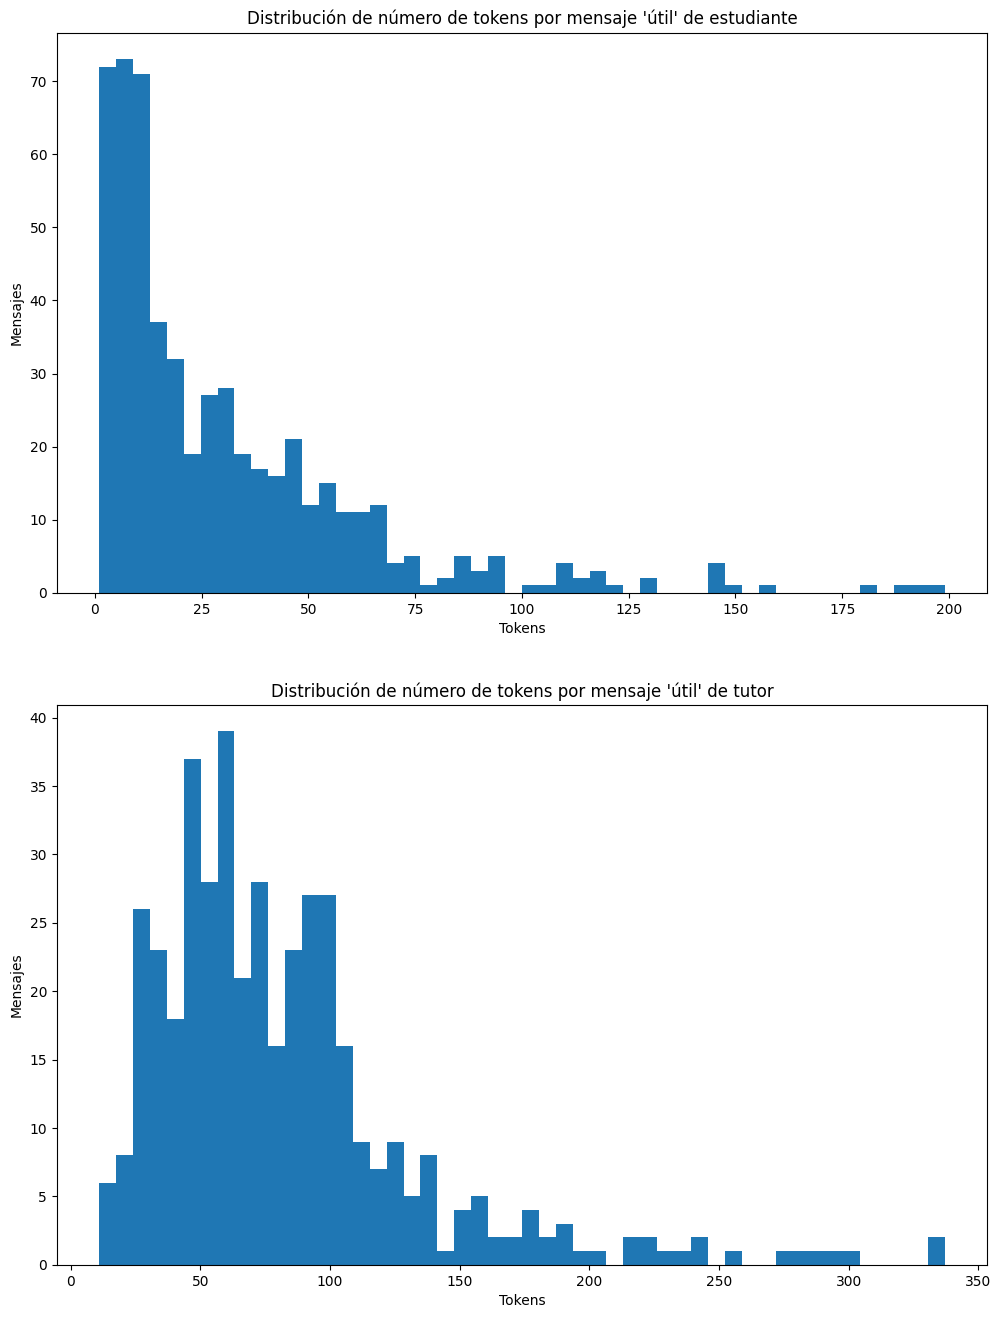

In [15]:
import spacy as sp
from filterTools import filter
import matplotlib.pyplot as mlp

tutors = [0, 2, 34, 50, 115, 959]
# tutors = filter('db/messages_anon_js_T.csv', lambda msg: msg['from_moderator'] == 'TRUE', saveField='sender_uid')

msgsE = filter('db/messages_anon_js_T.csv', lambda msg: int(msg['sender_uid']) not in tutors)
msgsT = filter('db/messages_anon_js_T.csv', lambda msg: int(msg['sender_uid']) in tutors)

nlp = sp.load('es_core_news_sm')
lengthsE = [len(nlp(msg['content'])) for msg in msgsE]
lengthsT = [len(nlp(msg['content'])) for msg in msgsT]

mlp.rcParams['figure.figsize'] = [12, 16]
sp1 = mlp.subplot(2, 1, 1)
sp1.set_title("Distribución de número de tokens por mensaje 'útil' de estudiante")
sp1.set_xlabel("Tokens")
sp1.set_ylabel("Mensajes")
msgHist = mlp.hist(lengthsE, bins=50)

sp2 = mlp.subplot(2, 1, 2)
sp2.set_title("Distribución de número de tokens por mensaje 'útil' de tutor")
sp2.set_xlabel("Tokens")
sp2.set_ylabel("Mensajes")
msgHist = mlp.hist(lengthsT, bins=50)
mlp.show()

Siguiente, un histograma de cantidad de mensajes por estudiante.

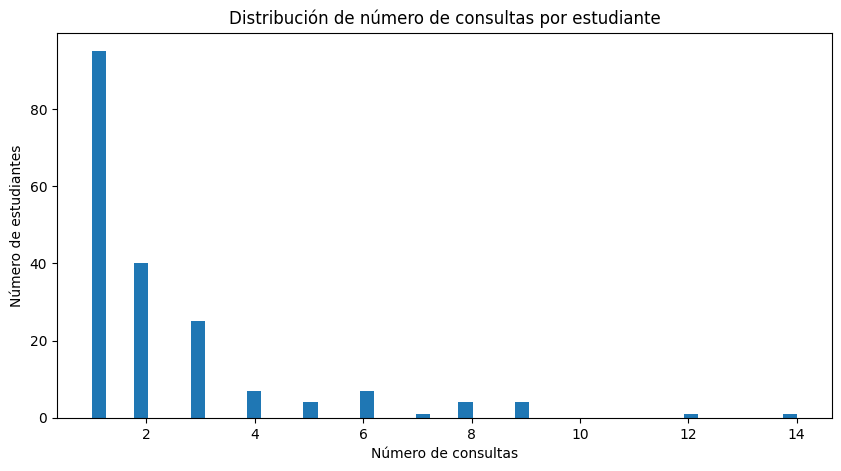

In [16]:
from filterTools import filter
import matplotlib.pyplot as mlp

tutors = [0, 2, 34, 50, 115, 959]

# users = filter('db/participants_anon.csv', lambda user: int(user['uid']) not in tutors)
msgs = filter('db/discussions_anon_js_T.csv', lambda msg: int(msg['initiator_uid']) not in tutors)

msgsDens = {}
for msg in msgs:
  user = msg['initiator_uid']
  msgsDens[user] = msgsDens.get(user, 0) + 1

mlp.rcParams['figure.figsize'] = [10, 5]
mlp.title("Distribución de número de consultas por estudiante")
mlp.xlabel('Número de consultas')
mlp.ylabel('Número de estudiantes')
mlp.hist(list(msgsDens.values()), bins=50)
mlp.show()

Lo último: análisis de **vocabulario** de estudiantes y tutores. Spacy tiene una clase **Vocab**, pero esta quizás se sale un poco de la utilidad simple que buscamos aquí; para empezar, el *Vocab* base ya viene con 420 palabras por defecto (que deberían ser signos de puntuación genéricos). Además, si queremos calcular la *frecuencia* de cada palabra, nos conviene usar diccionarios, igual que como venimos haciendo.

Tamaño de vocabulario de estudiantes: 2765
Tamaño de vocabulario de tutores: 2066


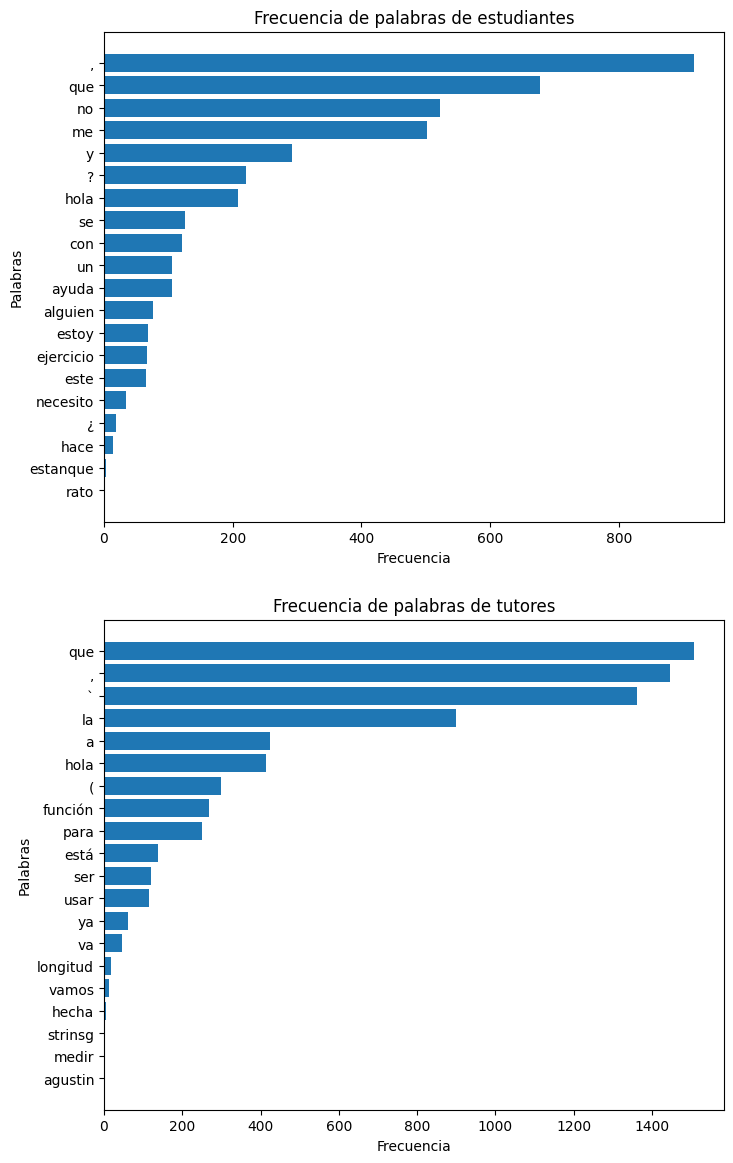

In [18]:
import spacy as sp
from filterTools import filter
import matplotlib.pyplot as mlp
import pandas as pd
from functools import reduce
import re

tutors = [0, 2, 34, 50, 115, 959]

nlp = sp.load('es_core_news_sm')
discsE = filter('db/discussions_anon_js_T.csv', lambda disc: int(disc['initiator_uid']) not in tutors)
msgsE = filter('db/messages_anon_js_T.csv', lambda msg: int(msg['sender_uid']) not in tutors)
# discsT = filter('db/discussions_anon_js_T.csv', lambda disc: int(disc['initiator_uid']) in tutors)  (empty)
msgsT = filter('db/messages_anon_js_T.csv', lambda msg: int(msg['sender_uid']) in tutors)

# Función para filtrar el código en markadown (lamentablemente, solo funciona si esta delimitado por ```)
def filter_md(msg):
  return re.sub(r'```.*```', '', msg, flags=re.DOTALL)

# Primero guardar el vocabulario + frecuencia por usuario
vocabE, vocabT = {}, {}
for disc in discsE:
  user = disc['initiator_uid']
  if user not in vocabE:
    vocabE[user] = {}
  text = nlp(filter_md(disc['description']))
  for token in text:
    word = token.text.lower()
    vocabE[user][word] = vocabE[user].get(word, 0) + 1
for msg in msgsE:
  user = msg['sender_uid']
  if user not in vocabE:
    vocabE[user] = {}
  text = nlp(filter_md(msg['content']))
  for token in text:
    word = token.text.lower()
    vocabE[user][word] = vocabE[user].get(word, 0) + 1

for msg in msgsT:
  user = msg['sender_uid']
  if user not in vocabT:
    vocabT[user] = {}
  text = nlp(filter_md(msg['content']))
  for token in text:
    word = token.text.lower()
    vocabT[user][word] = vocabT[user].get(word, 0) + 1

# Ahora tenemos el vocabulario general usado por cada persona
# Podemos analizar la frecuencia de palabras globalmente, como hicimos antes
# O podemos ver la variedad de palabras que usa cada usuario
vocabGeneralE = {}
for user in vocabE:
  for word in vocabE[user]:
    vocabGeneralE[word] = vocabGeneralE.get(word, 0) + vocabE[user][word]

vocabGeneralT = {}
for user in vocabT:
  for word in vocabT[user]:
    vocabGeneralT[word] = vocabGeneralT.get(word, 0) + vocabT[user][word]

vocabVarE = {}
for user in vocabE:
  vocabVarE[user] = set()
  for word in vocabE[user]:
    vocabVarE[user].add(word)

vocabVarT = {}
for user in vocabT:
  vocabVarT[user] = set()
  for word in vocabT[user]:
    vocabVarT[user].add(word)

# Desde aca empezamos a graficar
mlp.rcParams['figure.figsize'] = [8, 14]

sp1 = mlp.subplot(2, 1, 1)
sp1.set_title("Frecuencia de palabras de estudiantes")
sp1.set_xlabel("Frecuencia")
sp1.set_ylabel("Palabras")
df = pd.DataFrame(
    dict(
        words = list(vocabGeneralE.keys())[:20],
        freq = list(vocabGeneralE.values())[:20]
    )
)
mlp.barh('words', 'freq', data=df.sort_values('freq'))

sp2 = mlp.subplot(2, 1, 2)
sp2.set_title("Frecuencia de palabras de tutores")
sp2.set_xlabel("Frecuencia")
sp2.set_ylabel("Palabras")
df = pd.DataFrame(
    dict(
        words = list(vocabGeneralT.keys())[:20],
        freq = list(vocabGeneralT.values())[:20]
    )
)
mlp.barh('words', 'freq', data=df.sort_values('freq'))

vocabTotalE = reduce(lambda a, b: a.union(b), list(vocabVarE.values()))
vocabTotalT = reduce(lambda a, b: a.union(b), list(vocabVarT.values()))
print(f'Tamaño de vocabulario de estudiantes: {len(vocabTotalE)}')
print(f'Tamaño de vocabulario de tutores: {len(vocabTotalT)}')

#sp3 = mlp.subplot(2, 2, 3)
#sp3.set_title("Distribución de tamaños de vocabularios de estudiantes")
#sp3.set_xlabel("Tamaño en palabras")
#sp3.set_ylabel("Estudiantes")
#mlp.hist([len(v) for v in list(vocabVarE.values())], bins=30)

#sp4 = mlp.subplot(2, 2, 4)
#sp4.set_title("Distribución de tamaños de vocabularios de tutores")
#sp4.set_xlabel("Tamaño en palabras")
#sp4.set_ylabel("Tutores")
#mlp.hist([len(v) for v in list(vocabVarT.values())], bins=30)

mlp.show()

Nos interesa ver, de paso, cómo afecta la inclusión de cada criterio (enumerados 1, 2 y 3 por el orden en que se dieron) al filtro general, tanto para estudiantes como tutores. Para interpretar bien los resultados, hay que recordar que:

* El criterio 1 (discusiones resueltas) no alcanza, como ya vimos; alguna combinación de los criterios 2 y 3 es necesaria.
* Si el criterio 2 (mensajes de tutores) agrega resultados, es porque efectivamente había mensajes de tutores en discusiones cerradas. Pero si agrega menos resultados que el total (el resultado final), es porque hay mensajes validados en lugares donde los tutores no escriben.
* Si el criterio 3 (mensajes validados) agrega resultados por su cuenta, quiere decir que se están cerrando discusiones que tienen mensajes que fueron considerados "útiles" en algún punto (ojo con esto!), y si no agrega el total, es porque algún tutor escribe en donde no hay mensajes validados, y en particular, su propio mensaje no está validado (ojo con esto también!)

In [19]:
from filterTools import filter

tutors = [0, 2, 34, 50, 115, 959]

tutMsgs = filter('db/messages_anon_js.csv', lambda msg: int(msg['sender_uid']) in tutors, saveField='discussion_id')

def crit1(disc):
  return disc['status'] == 'solved'

def crit2(disc):
  return disc['id'] in tutMsgs

def crit3(disc):
  return int(disc['validated_messages_count']) > 0

def crit12(disc):
  return crit1(disc) or crit2(disc)

def crit13(disc):
  return crit1(disc) or crit3(disc)

def crit123(disc):
  return crit1(disc) or crit2(disc) or crit3(disc)

def crit1Ex(disc):
  return crit1(disc) and not crit2(disc) and not crit3(disc)

def crit2Ex(disc):
  return crit2(disc) and not crit1(disc) and not crit3(disc)

def crit3Ex(disc):
  return crit3(disc) and not crit1(disc) and not crit2(disc)

def crit23Ex(disc):
  return (crit2(disc) or crit3(disc)) and not crit1(disc)

def critAnd123(disc):
  return crit1(disc) and crit2(disc) and crit3(disc)

crit1_res = filter('db/discussions_anon_js.csv', crit1)
crit12_res = filter('db/discussions_anon_js.csv', crit12)
crit13_res = filter('db/discussions_anon_js.csv', crit13)
crit123_res = filter('db/discussions_anon_js.csv', crit123)
crit1Ex_res = filter('db/discussions_anon_js.csv', crit1Ex)
crit2Ex_res = filter('db/discussions_anon_js.csv', crit2Ex)
crit3Ex_res = filter('db/discussions_anon_js.csv', crit3Ex)
crit23Ex_res = filter('db/discussions_anon_js.csv', crit23Ex)
critAnd123_res = filter('db/discussions_anon_js.csv', critAnd123)

print(f'discusiones que cumplen criterio 1: {len(crit1_res)}')
print(f'discusiones que cumplen criterio 1 o 2: {len(crit12_res)}')
print(f'discusiones que cumplen criterio 1 o 3: {len(crit13_res)}')
print(f'discusiones que cumplen criterio 1, 2 o 3: {len(crit123_res)}')
print(f'discusiones que cumplen exclusivamente criterio 1: {len(crit1Ex_res)}')
print(f'discusiones que cumplen exclusivamente criterio 2: {len(crit2Ex_res)}')
print(f'discusiones que cumplen exclusivamente criterio 3: {len(crit3Ex_res)}')
print(f'discusiones que cumplen criterio 2 o 3, pero no 1: {len(crit23Ex_res)}')
print(f'discusiones que cumplen todos los criterios: {len(critAnd123_res)}')


discusiones que cumplen criterio 1: 55
discusiones que cumplen criterio 1 o 2: 422
discusiones que cumplen criterio 1 o 3: 441
discusiones que cumplen criterio 1, 2 o 3: 441
discusiones que cumplen exclusivamente criterio 1: 1
discusiones que cumplen exclusivamente criterio 2: 0
discusiones que cumplen exclusivamente criterio 3: 19
discusiones que cumplen criterio 2 o 3, pero no 1: 386
discusiones que cumplen todos los criterios: 9


Vale comprobar, a partir de estos resultados, si los mensajes de tutores son necesariamente validados o no.

In [20]:
from filterTools import filter

tutors = [0, 2, 34, 50, 115, 959]

tutMsgs = filter('db/messages_anon_js.csv', lambda msg: int(msg['sender_uid']) in tutors, saveField='id')
apprMsgs = filter('db/messages_anon_js.csv', lambda msg: msg['approved'] == 'TRUE', saveField='id')


print(f'Todos los mensajes de tutores son validados? -> {tutMsgs.issubset(apprMsgs)}')

# tutNotValMsgs = filter('db/messages_anon_js.csv', lambda msg: int(msg['sender_uid']) in tutors and msg['approved'] == 'FALSE', write=True, tag='-tNV')

print(f'Ningún mensaje de tutor es validado? -> {not len(tutMsgs.intersection(apprMsgs))}')

Todos los mensajes de tutores son validados? -> False
Ningún mensaje de tutor es validado? -> True


A partir de aquí repetiremos (casi) todos los resultados anteriores sobre la base de datos más grande, **base2022**.

In [ ]:
%run consistency_check.py db_base2022/discussions_anon_complete.csv db_base2022/messages_anon_complete.csv db_base2022/items_anon_complete_js.csv db_base2022/participants_anon_complete.csv

In [ ]:
from filterTools import filter

discs = len(filter('db_base2022/discussions_anon_complete.csv', lambda _: True))
msgs = len(filter('db_base2022/messages_anon_complete.csv', lambda _: True))
items = len(filter('db_base2022/items_anon_complete_js.csv', lambda _: True))

print(f'Número de discusiones: {discs}')
print(f'Número de mensajes: {msgs}')
print(f'Número de ejercicios (js): {items}')

In [ ]:
from filterTools import filter

tutors = filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['from_moderator'] == 'True', saveField='sender_uid')

js_items = filter('db_base2022/items_anon_complete_js.csv', lambda _: True, saveField='id')
approved_discs = filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['approved'] == 'True' or msg['sender_uid'] in tutors, saveField='discussion_id')

def usefulDisc(disc):
  return (disc['status'] != 'closed' or disc['id'] in approved_discs)

discsT = filter('db_base2022/discussions_anon_complete.csv', usefulDisc, write=True, tag='_T', saveField='id')
msgsT = filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['discussion_id'] in discsT, write=True, tag='_T')

print(f'Número de ejercicios de javascript: {len(js_items)}')
print(f'Número de discusiones que cumplen todos los criterios: {len(discsT)}')
print(f'Número de mensajes que cumplen todos los criterios: {len(msgsT)}')


In [ ]:
from filterTools import filter

tutors = filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['from_moderator'] == 'True', saveField='sender_uid')

tutMsgs = filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['sender_uid'] in tutors, saveField='discussion_id')
valMsgs = filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['approved'] == 'True', saveField='discussion_id')

def crit1(disc):
  return disc['status'] != 'closed'

def crit2(disc):
  return disc['id'] in tutMsgs

def crit3(disc):
  return disc['id'] in valMsgs

def crit12(disc):
  return (crit1(disc) or crit2(disc))

def crit13(disc):
  return (crit1(disc) or crit3(disc))

def crit123(disc):
  return (crit1(disc) or crit2(disc) or crit3(disc))

def crit1Ex(disc):
  return (crit1(disc) and not crit2(disc) and not crit3(disc))

def crit2Ex(disc):
  return (crit2(disc) and not crit1(disc) and not crit3(disc))

def crit3Ex(disc):
  return (crit3(disc) and not crit1(disc) and not crit2(disc))

def crit23Ex(disc):
  return ((crit2(disc) or crit3(disc)) and not crit1(disc))

def critAnd123(disc):
  return (crit1(disc) and crit2(disc) and crit3(disc))

crit1_res = filter('db_base2022/discussions_anon_complete.csv', crit1)
crit12_res = filter('db_base2022/discussions_anon_complete.csv', crit12)
crit13_res = filter('db_base2022/discussions_anon_complete.csv', crit13)
crit123_res = filter('db_base2022/discussions_anon_complete.csv', crit123)
crit1Ex_res = filter('db_base2022/discussions_anon_complete.csv', crit1Ex)
crit2Ex_res = filter('db_base2022/discussions_anon_complete.csv', crit2Ex)
crit3Ex_res = filter('db_base2022/discussions_anon_complete.csv', crit3Ex)
crit23Ex_res = filter('db_base2022/discussions_anon_complete.csv', crit23Ex)
critAnd123_res = filter('db_base2022/discussions_anon_complete.csv', critAnd123)

print(f'discusiones que cumplen criterio 1: {len(crit1_res)}')
print(f'discusiones que cumplen criterio 1 o 2: {len(crit12_res)}')
print(f'discusiones que cumplen criterio 1 o 3: {len(crit13_res)}')
print(f'discusiones que cumplen criterio 1, 2 o 3: {len(crit123_res)}')
print(f'discusiones que cumplen exclusivamente criterio 1: {len(crit1Ex_res)}')
print(f'discusiones que cumplen exclusivamente criterio 2: {len(crit2Ex_res)}')
print(f'discusiones que cumplen exclusivamente criterio 3: {len(crit3Ex_res)}')
print(f'discusiones que cumplen criterio 2 o 3, pero no 1: {len(crit23Ex_res)}')
print(f'discusiones que cumplen todos los criterios: {len(critAnd123_res)}')

In [ ]:
from filterTools import filter

tutors = filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['from_moderator'] == 'TRUE', saveField='sender_uid')

diffDiscs = filter('db_base2022/discussions_anon_complete_T.csv', lambda disc: disc['status'] != 'solved' and disc['status'] != 'closed', write=True, saveField= 'id')
_ = filter('db_base2022/messages_anon_complete_T.csv', lambda msg: msg['discussion_id'] in diffDiscs, write=True)

In [ ]:
from filterTools import filter
import numpy as np
import matplotlib.pyplot as mlp
from math import sqrt

msgs = filter('db_base2022/messages_anon_complete_T.csv', lambda _: True)
disc_msgs = {}
for msg in msgs:
  key = msg['discussion_id']
  disc_msgs[key] = disc_msgs.get(key, 1) + 1
discs = list(disc_msgs.values())

msgMean = round(np.mean(discs), 3)
msgVar = round(np.var(discs), 3)

mlp.rcParams['figure.figsize'] = [10, 6]
mlp.title("Distribución de número de mensajes por discusion 'útil'")
mlp.xlabel('Número de mensajes')
mlp.ylabel('Número de discusiones')
msgHist = mlp.hist(discs, bins=range(min(discs), max(discs)+1,))
mlp.show()
print(f'Promedio de mensajes: {msgMean} - Desviación estándar: {sqrt(msgVar)}')
print(f'Número máximo de mensajes: {max(discs)+1}')

In [ ]:
from filterTools import filter

tutors = [0, 2, 34, 50, 115, 959]

tutMsgs1 = filter('db/messages_anon_js_T.csv', lambda msg: int(msg['sender_uid']) in tutors)
tutMsgs2 = filter('db_base2022/messages_anon_complete_T.csv', lambda msg: int(msg['sender_uid']) in tutors)

print(f'Mensajes de tutores en base tiny: {len(tutMsgs1)}')
print(f'Mensajes de tutores en base 2022: {len(tutMsgs2)}')

Puntos importantes que surgen:

* Hay muchos menos mensajes de tutores en la DB nueva. Antes: 422 de 964 (43.68%). Ahora: 68 de 9664 (0,7%). Y esto es luego de aplicar los 3 criterios! Hay que ver que sean los mismos IDs de tutores.

Notamos que esta vez, los mensajes que son de mentores deberían presentar el flag "from_moderator". Como la nueva BD es grande y compleja, en lugar de asegurar esto, asumimos sólo lo opuesto: que si tiene el flag => es mentor. Usamos esa técnica para obtener los nuevos IDs (y corregir los códigos anteriores).

In [ ]:
from filterTools import filter

tutors1 = [0, 2, 34, 50, 115, 959]
tutors2 = filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['from_moderator'] == 'TRUE', saveField='sender_uid')

tutMsgs1 = filter('db/messages_anon_js.csv', lambda msg: int(msg['sender_uid']) in tutors1)
tutMsgs2 = filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['sender_uid'] in tutors2)

print(f'Mensajes de tutores en base tiny: {len(tutMsgs1)}')
print(f'Mensajes de tutores en base 2022: {len(tutMsgs2)}')

In [ ]:
from filterTools import filter

print(len(filter('db_base2022/messages_anon_complete.csv', lambda msg: msg['from_moderator'] == 'TRUE', saveField='sender_uid')))

In [ ]:
import re

def filter_md(msg):
  return re.sub(r'```.*```', '', msg, flags=re.DOTALL)

msg = "hola que ```algun \n codigo bien feo```tal como va"
print(filter_md(msg))

Antes de empezar con la siguiente etapa, consideramos lo que necesitaremos como datos de entrada para entrenar nuestras redes. Planeamos hacer una primera prueba en la que la red adivine, para cada mensaje, a cual ejercicio (de 120) corresponde. Pero en en principio, hay muchísimos mensajes en los que sería imposible que le atine - algunos vacíos y otros de pocas palabras, como "gracias" o "ayuda", que entran en nuestros criterios de selcción por estar en una discusión "útil". Una opción es filtrar también estos mensajes, y de lo que queda, tendremos que ver qué longitud encontramos *en caracteres*. Pero en verdad, lo que quizás tenga más sentido es identificar *conversaciones* como bloques, siendo que cada una se refiere a cierto ejercicio (lo cual tenemos como dato, sirviéndonos para aprendizaje supervisado). Esto nos evitaría tener que eliminar aún más datos - y le otorgaría a la red más contexto *real* sobre las conversaciones que puede encontrar.

Consideremos un nuevo "tipo" de dato, llamado *chat*, que al igual que los contenidos de las discusiones y los mensajes, es un simple string; un texto formado por la concatenación de todos los mensajes en una discusión (incluyendo el *inicial*) separados por un espacio. Sobre esto calcularemos cantidad de caracteres.

In [ ]:
from filterTools import filter
import matplotlib.pyplot as mlp
import numpy as np
from math import sqrt

discs = filter('db_base2022/discussions_anon_complete_T.csv', lambda _: True)
msgs = filter('db_base2022/messages_anon_complete_T.csv', lambda _: True)
chats = []
for disc in discs:
  chat = disc['description']
  for i, msg in enumerate(msgs):
    if disc['id'] == msg['discussion_id']:
      chat += ' ' + msg['content']
      msgs.pop(i)
  chats.append(chat)

chat_chars = [len(chat) for chat in chats if len(chat) <= 5000]
charMean = round(np.mean(chat_chars), 3)
charVar = round(np.var(chat_chars), 3)

mlp.rcParams['figure.figsize'] = [12, 6]
mlp.title("Distribución de número de caracteres por conversación")
mlp.xlabel('Número de caracteres')
mlp.ylabel('Número de conversaciones')
mlp.hist(chat_chars, bins=range(min(chat_chars), max(chat_chars), 10))
mlp.show()
print(f'Promedio de caracteres: {charMean} - Desviación estándar: {sqrt(charVar)}')
print(f'Número máximo de caracteres: {max(chat_chars)}')
print(f'Número de conversaciones: {len(chat_chars)}')


La herramienta que (probablemente) usaremos para entrenar modelos es scikit-learn (en Python!). La primera investigación nos revela que un patrón de uso común de scikit-learn con clasificación de texto es primero organizar los fragmentos (las conversaciones, en nuestro caso) en un conjunto de datos, tokenizar, y luego entrenar (y aquí podremos elegir distintos algoritmos). Nuestra primera dificultad es que el tokenizador de scikit-learn es limitado; en primer lugar, tiene sólo soporte para inglés. Afortunadamente, los desarrolladores de dicha librería concibieron la posibilidad de usar *otro* tokenizador externo.

La última tarea en este notebook será replicar el gráfico anterior pero con largo en *tokens* (como se generan con Spacy), que será más probablemente lo que usaremos. Notar que esta vez, no hace falta concatenar strings; en lugar de eso concatenamos *listas* en las que ya están separados los tokens. Adicionalmente, probamos por primera vez desactivar los componentes de Spacy que no usamos (los que sirven para catalogar texto, identificar estructuras gramaticales, funciones de palabras, etc.) para aumentar la eficiencia.

In [ ]:
from filterTools import filter
import matplotlib.pyplot as mlp
import numpy as np
from math import sqrt
import spacy as sp

nlp = sp.load('es_core_news_sm', enable=['tagger', 'parser', 'ner', 'entity_linker', 'entity_ruler'])

discs = filter('db_base2022/discussions_anon_complete_T.csv', lambda _: True)
msgs = filter('db_base2022/messages_anon_complete_T.csv', lambda _: True)
chats = []
for disc in discs:
  chat = [] if len(disc['description']) == 0 else [token.text for token in nlp(disc['description'])]
  for i, msg in enumerate(msgs):
    if disc['id'] == msg['discussion_id']:
      chat += [token.text for token in nlp(msg['content'])]
      msgs.pop(i)
  chats.append(chat)

chat_tokens = [len(chat) for chat in chats if len(chat) <= 1000]
tokenMean = round(np.mean(chat_tokens), 3)
tokenVar = round(np.var(chat_tokens), 3)

mlp.rcParams['figure.figsize'] = [12, 6]
mlp.title("Distribución de número de tokens por conversación")
mlp.xlabel('Número de tokens')
mlp.ylabel('Número de conversaciones')
mlp.hist(chat_tokens, bins=range(min(chat_tokens), max(chat_tokens)))
mlp.show()
print(f'Promedio de tokens: {tokenMean} - Desviación estándar: {sqrt(tokenVar)}')
print(f'Número máximo de tokens: {max(chat_tokens)}')
print(f'Número de conversaciones: {len(chat_tokens)}')